In [4]:
import numpy as np
import matplotlib.pyplot as plt  # Plotting library
import gd,sgd,newton,make_plots,pgd
import importlib as imp


import numdifftools as nd
from scipy.optimize import check_grad
import scipy
import pickle
%matplotlib inline
import seaborn as sns

sns.set_style("whitegrid")

### (i) Create Data

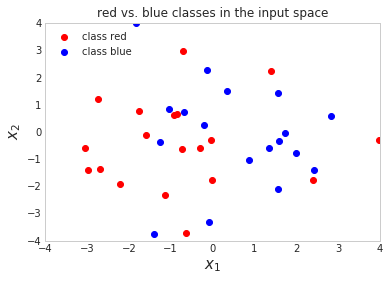

In [5]:
# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
red_mean = [-1,0,1,-0.5,1,2,0,4,1]  # The mean of the red class
green_mean = [-0.5,3,1,0.5,2,4,0,2,2]

blue_mean = [1,0,-1,-0.5,2,1,-1,0,3]  # The mean of the blue class
yellow_mean = [2,-0.1,-1.5,-0.4,1,0.5,0,1,4]

std_dev = 2  # standard deviation of both classes
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, len(red_mean)) * std_dev + red_mean
x_green = np.random.randn(nb_of_samples_per_class, len(green_mean)) * std_dev + green_mean


x_blue = np.random.randn(nb_of_samples_per_class, len(blue_mean)) * std_dev + blue_mean
x_yellow = np.random.randn(nb_of_samples_per_class, len(yellow_mean)) * std_dev + yellow_mean


# Merge samples in set of input variables x, and corresponding set of output variables t
X = np.vstack((x_red,x_green, x_blue,x_yellow))
y_1=np.zeros(nb_of_samples_per_class*2)
y_2=np.ones(nb_of_samples_per_class*2)
y=np.concatenate((y_1,y_2))

# Plot both classes on the x1, x2 plane
#plt.plot(x_green[:,0], x_green[:,1], 'go', label='class green')
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-4, 4, -4, 4])
plt.title('red vs. blue classes in the input space')
plt.show()



In [6]:
X=np.load('saddle_X.npy')
y=np.load('saddle_y.npy')
saddle_point=np.load('saddle_w.npy')



### (ii) Define and plot perceptron loss

In [7]:
### robust sigmoid computation that can work on vectors:
def sigmoid(t):
    # logistic function returns 1 / (1 + exp(-t))
    idx = t > 0
    out = np.empty(t.size, dtype=np.float)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out 

### Perceptron risk
def get_loss(w,X,y,lambd=0): 
    n,d = X.shape
    subopt= sigmoid(-y*np.dot(X,w))
    subopt = np.dot(np.ones(n),subopt)/float(n) + 0.5*lambd*np.dot(w.transpose(),w)
    return subopt

def get_gradient(w,X,y,lambd=0): 
    n,d = X.shape
    sig=sigmoid(-y*np.dot(X,w))
    sig_prime=sig*(1-sig)
    return np.dot(X.transpose(),-y*sig_prime)/float(n)+lambd*w

def get_hessian(w,X,y,lambd=0):
    n,d = X.shape
    h = np.zeros((d,d))
    sig=sigmoid(-y*np.dot(X,w))
    sig_prime=sig*(1-sig)
    sig_prime_prime=-2*sig*sig_prime+sig_prime
    H=np.dot(X.transpose(),X*(y**2*sig_prime_prime)[:, np.newaxis])/float(n)+ np.eye(d)*lambd
    return H


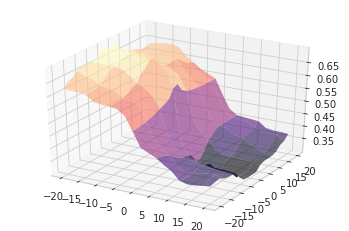

In [8]:
# initialize loss matrix
nb_of_ws = 20 
ws1 = np.linspace(-20, 20, num=nb_of_ws) # weight 1
ws2 = np.linspace(-20, 20, num=nb_of_ws) # weight 2
ws_x, ws_y = np.meshgrid(ws1, ws2) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # 

# Fill the loss matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = get_loss(np.array((ws_x[i,j], ws_y[i,j])), X[:,0:2] , y)

# Plot the cost function surface

if False:
    plt.figure(1)

    plt.contourf(ws_x, ws_y, cost_ws, 20)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$\\xi$', fontsize=15)
    plt.xlabel('$w_1$', fontsize=15)
    plt.ylabel('$w_2$', fontsize=15)
    plt.title('Cost function surface')
    plt.grid()
    plt.show()

#3d plot of logistic loss surface
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')         # set the 3d axes
ax.plot_surface(ws_x, ws_y, cost_ws, 
               rstride=3, 
              cstride=3,
             alpha=0.6,  cmap=cm.magma)         # colour map

if X.shape[1]<3:
    if  SGD:
        ax.scatter(SGD_steps[:,0], SGD_steps[:,1],SGD_loss,s=45,marker='x',c='g', zorder=280, linewidth='2',alpha=0.9, label='SGD')

    if  NEWTON:
        ax.scatter(NEWTON_steps[:,0], NEWTON_steps[:,1],NEWTON_loss,s=45,marker='x',c='k', zorder=280, linewidth='2',alpha=0.9, label='SGD')

### (iii) Run Methods

--- SGD ---
- Batch size: 1
- Learning rate: 0.25
--- GD ---
- Batch size: 40
- Learning rate: 0.25
--- PGD ---
- Batch size: 40
- Learning rate: 0.25
pertubs 2
4002
4001
4001


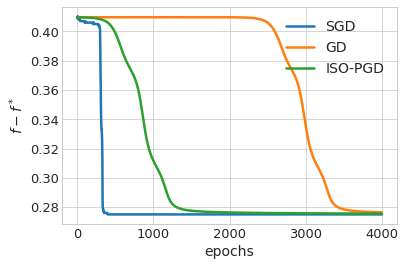

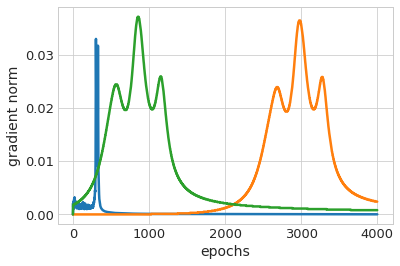

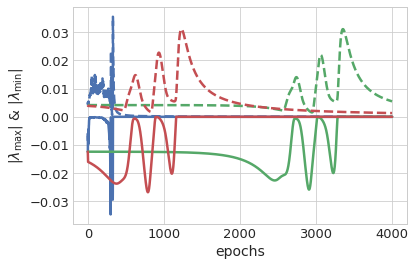

In [10]:
def show_plots(x_limits_time=None):
    list_params=[]
    list_loss=[]
    list_x=[]
    list_samples=[]
    list_grads=[]
    list_EVs=[]
    
    #plot options (non exclusive)
    log_scale=False  
    over_time=False
    over_iterations=False #(needs adaption for SGD)
    over_epochs=True
        
    if SGD:
        list_loss.append(np.round(SGD_loss,3))
        list_x.append(SGD_x)
        list_samples.append(SGD_samples)
        list_grads.append(SGD_grads)
        list_EVs.append(SGD_EVs)
        list_params.append('SGD')
    if GD:
        list_loss.append(np.round(GD_loss,5))
        list_x.append(GD_x)
        list_samples.append(GD_samples)
        list_grads.append(np.round(GD_grads,4))
        list_EVs.append(GD_EVs)
        list_params.append('GD')
    
    if PGD:
        list_loss.append(np.round(PGD_loss,5))
        list_x.append(PGD_x)
        list_samples.append(PGD_samples)
        list_grads.append(np.round(PGD_grads,4))
        list_EVs.append(PGD_EVs)
        list_params.append('ISO-PGD')
    
    if NEWTON:
        list_loss.append(np.round(NEWTON_loss,3))
        list_x.append(NEWTON_x)
        list_samples.append(NEWTON_samples)
        list_grads.append(np.round(NEWTON_grads,4))
        list_EVs.append(NEWTON_EVs)
        list_params.append('NEWTON')      
        
    if over_time:
        make_plots.two_d_plot_time(list_loss,list_x,list_params,list_grads,'test', 40, 2, log_scale,x_limits=x_limits_time)
        
    if over_iterations:
        make_plots.two_d_plot_iterations(list_loss,list_x,list_params,list_grads,'test', 40, 2, log_scale)
        
    if over_epochs:
        two_d_plot_epochs_all_in_one(list_loss,list_samples,list_params,list_grads,list_EVs,'test', X.shape[0], X.shape[1], log_scale)


opt = {}
opt['print_progress']=False

opt['n_epochs_sgd']=4000
opt['n_epochs_gd']=4000
opt['n_epochs_newton']=100

opt['n_epochs_pgd']=4000
opt['radius_pgd']=0.1
opt['g_thres_pgd']=0.001



opt['learning_rate_sgd']=0.25
opt['learning_rate_gd']=0.25
opt['learning_rate_pgd']=0.25
opt['learning_rate_newton']=0.1

opt['batch_size_sgd']=X.shape[0]/10
opt['batch_size_sgd']=1


loss_args={}

SGD    = True
GD     = True
PGD    = True
NEWTON = False


no_of_runs=1

#w=saddle_point+np.random.uniform(-0.0001,0.001,X.shape[1])
w=np.load('truly_good_initialization.npy')

#w=np.random.randn(X.shape[1])*2

#w=w_GD_safe[1000]

if SGD:       
    loss_collector=[]
    grads_collector=[]
    for k in range(no_of_runs):
        (w_SGD,SGD_x, _loss, SGD_samples,SGD_steps,_grads,SGD_EVs)=sgd.SGD(w,get_loss,get_gradient,get_hessian, X=X, Y=y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        grads_collector.append(_grads)
    SGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SGD_grads =[float(sum(col))/len(col) for col in zip(*grads_collector)]   

if GD:       
    loss_collector=[]
    grads_collector=[]
    for k in range(no_of_runs):
        (w_GD,GD_x, _loss, GD_samples,GD_steps,_grads,GD_EVs)=gd.GD(w,get_loss,get_gradient,get_hessian, X=X, Y=y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        grads_collector.append(_grads)
    GD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD_grads =[float(sum(col))/len(col) for col in zip(*grads_collector)]   

if PGD:       
    loss_collector=[]
    grads_collector=[]
    for k in range(no_of_runs):
        (w_PGD,PGD_x, _loss, PGD_samples,PGD_steps,_grads,PGD_EVs)=pgd.PGD(w,get_loss,get_gradient,get_hessian, X=X, Y=y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        grads_collector.append(_grads)
    PGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    PGD_grads =[float(sum(col))/len(col) for col in zip(*grads_collector)] 
    

if NEWTON:  
    (w_NEWTON,NEWTON_x, NEWTON_loss, NEWTON_samples,NEWTON_steps,NEWTON_grads, NEWTON_EVs)=newton.NEWTON(w,get_loss,get_gradient,get_hessian ,X=X, Y=y, opt=opt, **loss_args)
    
show_plots() 



In [9]:
import matplotlib
import matplotlib.pyplot as plt
import simplejson

def two_d_plot_epochs_all_in_one(list_loss, list_samples, list_params,list_grads,list_EVs, dataset_name, n, d, log_scale, x_limits=None):
    colors = ['#4c72b0','#55a868' ,'#c44e52', '#8172b2', '#2980B9', '#1E8449', '#27AE60', '#E67E22', '#95A5A6','#1B2631' ]
    linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
    import numpy as np
    #sns.set()
    #cool green: '#8BC34A'

    fig = plt.figure(1)

    list_x = [[j / n for j in i] for i in list_samples]
    for i in range(len(list_loss)):
        print(len(list_loss[i]))
        plt.plot(np.arange(len(list_loss[i])), list_loss[i], linestyles[i % 10], linewidth=2.5)

    plt.legend(list_params, fontsize=14, loc=1)
    if not x_limits == None:
        plt.xlim(x_limits)

    if log_scale == True:
        plt.yscale('log')
        plt.ylabel('$\log(f-f^*)$', fontsize=14)
    else:
        plt.yscale('linear')
        plt.ylabel('$f-f^*$', fontsize=14)

    plt.xlabel('epochs', fontsize=14)
    plt.tick_params(labelsize=13)


    plt.savefig('loss.pdf')

    fig=plt.figure(2)


    for i in range(len(list_grads)):
    	plt.plot(np.arange(len(list_grads[i])), list_grads[i], linestyles[i % 10],  linewidth=2.5)
    #plt.legend(list_params[i], fontsize=12, loc=1)

   
    plt.yscale('linear')
    plt.ylabel('gradient norm',fontsize=14)
    plt.xlabel('epochs', fontsize=14)
    plt.tick_params(labelsize=13)

    if not x_limits == None:
        plt.xlim(x_limits)
    plt.savefig('grads.pdf')


    fig=plt.figure(3)
    #show EVs
    current_palette = sns.color_palette()

    for i in range(len(list_loss)):
        plt.plot(np.arange(len(list_EVs[i][:,0])), list_EVs[i][:,0], '-', color=colors[i % 10], linewidth=2.5)
        plt.plot(np.arange(len(list_EVs[i][:,1])), list_EVs[i][:,1], '--' , color=colors[i % 10], linewidth=2.5)

    #plt.legend(list_params[i], fontsize=12, loc=1)

   
    plt.yscale('linear')
    plt.ylabel('$\| \lambda_{\max} \|$ & $\| \lambda_{\min} \|$',fontsize=14)
    plt.xlabel('epochs', fontsize=14)
    plt.tick_params(labelsize=13)

    if not x_limits == None:
        plt.xlim(x_limits)


    plt.savefig('EVs.pdf')

    plt.show
